## Pandas, SQLite 활용한 베스트 드라마 영화 찾기

- Pandas 예제에서 활용하였던 MovieLens 데이터를 활용합니다.
- 데이터는 실습을 위해 SQLite database 형태로, 같은 폴더 내 db 폴더 내부에 추가하였습니다. : /db/movie_ratings.db

- 기존에 실습에 활용한 데이터와의 차이점은 user 테이블 대신, tags 테이블이 존재합니다.

In [1]:
import sqlite3
import pandas.io.sql as sql

In [2]:
# movie_ratings.db와 연결
con = sqlite3.connect("./db/movie_ratings.db")

In [3]:
# 데이터가 잘 들어있는지 확인해보기
users = sql.read_sql_query("SELECT * FROM users;", con)
users.head()

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [4]:
movies = sql.read_sql_query("SELECT * FROM movies;", con)
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings = sql.read_sql_query("SELECT * FROM ratings;", con)
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### 드라마 영화 평점만 추출해보기

- ratings, movies 테이블의 조인이 필요합니다.

#### 1. 먼저 movies 테이블 genres에서 코미디가 포함된 영화만을 추출해봅니다.

In [6]:
drama_movies_query = """
    SELECT * FROM movies
    WHERE genres
    LIKE '%Drama%';
"""

drama_movies = sql.read_sql_query(drama_movies_query, con)

In [7]:
drama_movies.shape

(1603, 3)

#### 2. 위의 query에 ratings테이블을 조인하여, 평점 정보도 함께 추출합니다.

In [8]:
comb_movies_ratings_query = """
    SELECT * FROM movies
    INNER JOIN ratings
    ON movies.movie_id = ratings.movie_id
    WHERE genres LIKE '%Drama%'
    GROUP BY movies.movie_id;
"""

drama_movie_ratings = sql.read_sql_query(comb_movies_ratings_query, con)

In [9]:
drama_movie_ratings.shape

(1493, 7)

In [10]:
drama_movie_ratings.head()

,movie_id,title,genres,user_id,movie_id,rating,timestamp
0,4,Waiting to Exhale (1995),Comedy|Drama,6036,4,2,956753920
1,11,"American President, The (1995)",Comedy|Drama|Romance,6036,11,3,956752783
2,14,Nixon (1995),Drama,6016,14,3,956959191
3,16,Casino (1995),Drama|Thriller,6036,16,3,956753965
4,17,Sense and Sensibility (1995),Drama|Romance,6040,17,3,956704584


#### 3. ratings를 평균 값으로 추출합니다

In [11]:
avg_ratings_query = """
    SELECT movies.movie_id, 
            title, 
            count(ratings.rating), 
            AVG(ratings.rating) as avgr 
    FROM movies
    INNER JOIN ratings
    ON movies.movie_id = ratings.movie_id
    WHERE genres LIKE '%Drama%'
    GROUP BY movies.movie_id
    ORDER BY avgr DESC;
"""

movie_avg_ratings = sql.read_sql_query(avg_ratings_query, con)

In [12]:
movie_avg_ratings.head()

,movie_id,title,count(ratings.rating),avgr
0,989,Schlafes Bruder (Brother of Sleep) (1995),1,5.00
1,3382,Song of Freedom (1936),1,5.00
2,3607,One Little Indian (1973),1,5.00
3,3245,I Am Cuba (Soy Cuba/Ya Kuba) (1964),5,4.80
4,53,Lamerica (1994),8,4.75


#### rating의 갯수가 너무 적은 경우, 제외합니다.

In [13]:
avg_ratings_atleast_100_query = """
    SELECT movies.movie_id, 
            title, 
            count(ratings.rating) as cnt, 
            AVG(ratings.rating) as avgr 
    FROM movies
    INNER JOIN ratings
    ON movies.movie_id = ratings.movie_id
    WHERE genres LIKE '%Drama%'
    GROUP BY movies.movie_id
    HAVING cnt > 100
    ORDER BY avgr DESC;
"""

movie_avg_ratings_100 = sql.read_sql_query(avg_ratings_atleast_100_query, con)

In [14]:
top_15 = movie_avg_ratings_100[:15]
top_15

,movie_id,title,cnt,avgr
0,2019,Seven Samurai (The Magnificent Seven) (Shichin...,628,4.560510
1,318,"Shawshank Redemption, The (1994)",2227,4.554558
2,858,"Godfather, The (1972)",2223,4.524966
3,527,Schindler's List (1993),2304,4.510417
4,1178,Paths of Glory (1957),230,4.473913
5,1207,To Kill a Mockingbird (1962),928,4.425647
6,912,Casablanca (1942),1669,4.412822
7,3030,Yojimbo (1961),215,4.404651
8,1193,One Flew Over the Cuckoo's Nest (1975),1725,4.390725
9,923,Citizen Kane (1941),1116,4.388889


([<matplotlib.axis.YTick at 0x105f21c50>,
 <a list of 15 Text yticklabel objects>)

Text(0.5,0,'Average movie rating')

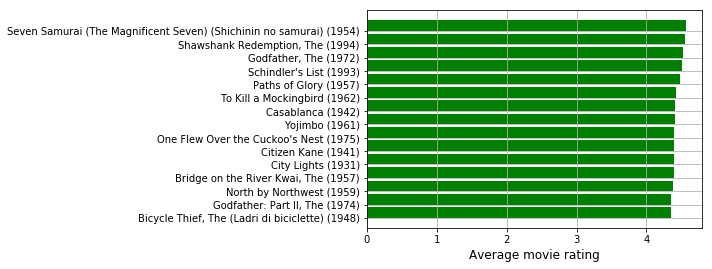

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.arange(len(top_15))

fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)

barlist = plt.barh(x, top_15['avgr'], color = "g",
                   edgecolor='none')
plt.yticks(x + 0.4, top_15['title'])
plt.gca().invert_yaxis()
plt.xlabel('Average movie rating', fontsize = 12)
plt.grid(True)